# Evaluation of MPT Portfolios (GMVP, MVP, MSRP) against EWP

## By: Young, James Yang

### Project Setup

Load packages

In [37]:
## import packages ##

# solver tools
import scipy
import cvxpy as cp

# basic data and math tools
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import empyrical as emp # for measuring financial risk
from pandas_datareader import data as pdr # for web scraping
import yfinance as yf # tool for download yahoo finance data
import requests # for web scraping data from sites that don't allw pdr.read_html directly
import re # try different replace string method

# portfolio optimization package
import pypfopt
from pypfopt import plotting

### Pick HSI and SP500 Stocks Data Randomly

Web Scrap SP500 Components

In [38]:
# get SP500 data from wikipedia and store as pandas dataframe
payload_sp500=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp500_components = payload_sp500[0] # S&P 500 component stocks
sp500_components.rename(columns={'GICS Sector':'Sector'},inplace=True) # rename for consistency
sp500_components.rename(columns={'Symbol':'Ticker'},inplace=True) # rename for consistency
sp500_components.rename(columns={'Security':'Name'},inplace=True) # rename for consistency
sp500_components['Ticker'] = sp500_components['Ticker'].apply(lambda x: x.replace(".", "")) # remove the string 'SEHK:'

# optional remove extra columns
del sp500_components['Headquarters Location']
del sp500_components['GICS Sub-Industry']
del sp500_components['CIK']
del sp500_components['Founded']
del sp500_components['Date added']

# show unique sectors in dataset
sp500_sectors = set(sp500_components['Sector'].values.tolist())
print("Unique Sectors: ")
print(sp500_sectors)

# interested only in the sp500 component stock table
sp500_components

Unique Sectors: 
{'Utilities', 'Health Care', 'Industrials', 'Real Estate', 'Materials', 'Information Technology', 'Financials', 'Consumer Discretionary', 'Energy', 'Communication Services', 'Consumer Staples'}


,Ticker,Name,Sector
0,MMM,3M,Industrials
1,AOS,A. O. Smith,Industrials
2,ABT,Abbott,Health Care
3,ABBV,AbbVie,Health Care
4,ACN,Accenture,Information Technology
...,...,...,...
497,YUM,Yum! Brands,Consumer Discretionary
498,ZBRA,Zebra Technologies,Information Technology
499,ZBH,Zimmer Biomet,Health Care
500,ZION,Zions Bancorporation,Financials


Web Scrap Hang Seng Index Components

In [39]:
# get HSI components from wikipedia table
payload_hsi=pd.read_html('https://en.wikipedia.org/wiki/Hang_Seng_Index')
hsi_components = payload_hsi[6]
hsi_components.rename(columns={'Sub-index':'Sector'},inplace=True)
# Change ticker to match yahoo finance
hsi_components['Ticker'] = hsi_components['Ticker'].apply(lambda x: x.replace("SEHK:", "")) # remove the string 'SEHK:'
hsi_components['Ticker'] = hsi_components['Ticker'].apply(lambda x: re.sub("[^0-9]", "", str(x))).astype(int) # remove white spaces
hsi_components['Ticker'] = hsi_components['Ticker'].apply(lambda x: '{0:0>4}'.format(x)) # pad zeros
hsi_components['Ticker'] = hsi_components['Ticker'].astype(str) + '.HK' # append .HK to each ticker
hsi_components['Sector'] = hsi_components['Sector'].apply(lambda x: x.replace("&", "and")) # replace symbol

# HSI sectors
hsi_sectors = set(hsi_components['Sector'].values.tolist())
print("Unique Sectors: ")
print(hsi_sectors)

hsi_components

Unique Sectors: 
{'Utilities', 'Commerce and Industry', 'Finance', 'Properties'}


,Ticker,Name,Sector
0,0005.HK,HSBC Holdings plc,Finance
1,0011.HK,Hang Seng Bank Ltd,Finance
2,0388.HK,HKEx Limited,Finance
3,0939.HK,China Construction Bank,Finance
4,1299.HK,AIA Group Limited,Finance
...,...,...,...
68,9618.HK,JD.com,Commerce and Industry
69,9633.HK,Nongfu Spring,Commerce and Industry
70,9888.HK,Baidu,Commerce and Industry
71,9988.HK,Alibaba Group,Commerce and Industry


Generate random stock namelist based on sectors

In [40]:
def pick_random_stock(list,num_stocks=1, seed=1):
    """
    Helper function that picks pseudo-random stocks of length num_stocks from passed list and returns the stocks picked. 
    Pseudo-random numbers generated with passed seed for reproducability.
    """
    # if input stocks greater than list, set to return stocks list length
    if num_stocks>len(list):
        num_stocks = len(list)
    # initialize random stock list
    random_stocks = list.sample(n=num_stocks,random_state=seed)
    return random_stocks

In [41]:
# initialize empty pandas dataframe
sp500_stocklist = pd.DataFrame()
hsi_stocklist = pd.DataFrame()
# add random picked stocks to dataframe
for sector in hsi_sectors:
    # print(sector)
    sector_df = hsi_components[hsi_components['Sector']==sector]
    random_stocks = pick_random_stock(sector_df,num_stocks=2,seed=110)
    hsi_stocklist = pd.concat([hsi_stocklist,random_stocks])

for sector in sp500_sectors:
    # print(sector)
    random_stocks = []
    sector_df = sp500_components[sp500_components['Sector']==sector]
    random_stocks = pick_random_stock(sector_df,num_stocks=1,seed=18)
    sp500_stocklist = pd.concat([sp500_stocklist,random_stocks])

In [42]:
print("Number of stocks: "+str(len(sp500_stocklist)))
sp500_stocklist.sort_values(by=['Sector'])

Number of stocks: 11


,Ticker,Name,Sector
5,ATVI,Activision Blizzard,Communication Services
286,LVS,Las Vegas Sands,Consumer Discretionary
232,HSY,Hershey's,Consumer Staples
43,APA,APA Corporation,Energy
454,TFC,Truist,Financials
314,MTD,Mettler Toledo,Health Care
463,URI,United Rentals,Industrials
234,HPE,Hewlett Packard Enterprise,Information Technology
166,ECL,Ecolab,Materials
196,FRT,Federal Realty,Real Estate


In [43]:
print("Number of stocks: "+str(len(hsi_stocklist)))
hsi_stocklist.sort_values(by=['Sector'])

Number of stocks: 8


,Ticker,Name,Sector
41,0857.HK,PetroChina Company Limited,Commerce and Industry
49,1044.HK,Hengan International Group Co. Ltd,Commerce and Industry
4,1299.HK,AIA Group Limited,Finance
5,1398.HK,Industrial and Commercial Bank of China,Finance
20,0688.HK,Hang Lung Properties Limited,Properties
21,0823.HK,China Overseas Land & Investment Limited,Properties
15,2688.HK,ENN Energy,Utilities
13,0006.HK,Power Assets Holdings Limited,Utilities


### Obtain largest weighted SP500 stocks

In [44]:
r = requests.get(url='https://www.slickcharts.com/sp500',headers={'User-Agent':'Mozilla/5.0'})
sp500_weighted = pd.read_html(r.text)[0]
sp500_weighted['Symbol'] = sp500_weighted['Symbol'].apply(lambda x: x.replace(".", "-"))

### Load data from Yahoo Finance

In [45]:
# convert dataframe symbols to list
hsi_symbols = hsi_stocklist['Ticker'].to_list()
sp500_symbols = sp500_stocklist['Ticker'].to_list()
sp500_top = sp500_weighted['Symbol'][:12].to_list()

In [46]:
print(sp500_top)
print(sp500_symbols)

['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'BRK-B', 'GOOG', 'META', 'XOM', 'UNH', 'TSLA', 'JNJ']
['DUK', 'MTD', 'URI', 'FRT', 'ECL', 'HPE', 'TFC', 'LVS', 'APA', 'ATVI', 'HSY']


In [47]:
def get_stock_prices(stock_symbol_list,start_date,end_date):
    """
    Download and return price data from YahooFinance based on passed stock symbol list and passed start and end date.
    """
    prices = yf.download(stock_symbol_list,start=start_date,end=end_date)
    return prices

In [48]:
# dates to get data from
start_date = "2021-01-01"
end_date = "2022-12-31"

# get randomly selected sp500 closing prices
sp500_prices = get_stock_prices(sp500_symbols,start_date,end_date)['Adj Close']

# use top 10 weighted sp500 prices
sp500_top_prices = get_stock_prices(sp500_top,start_date,end_date)['Adj Close']

# hsi prices
hsi_prices = get_stock_prices(hsi_symbols,start_date,end_date)['Adj Close']

[*********************100%***********************]  11 of 11 completed
[*********************100%***********************]  12 of 12 completed
[*********************100%***********************]  8 of 8 completed


Get Normalized and Log Returns

In [49]:
sp500_top_linear_returns = np.diff(sp500_top_prices,axis=0)/ sp500_top_prices[:-1]
sp500_top_linear_returns = sp500_top_linear_returns.dropna()
sp500_top_logret = sp500_top_prices.apply(np.log).apply(np.diff)
sp500_top_logret = sp500_top_logret.dropna()

sp500_linear_returns = np.diff(sp500_prices,axis=0)/ sp500_prices[:-1]
sp500_linear_returns = sp500_linear_returns.dropna()
sp500_logret = sp500_prices.apply(np.log).apply(np.diff)
sp500_logret = sp500_logret.dropna()

hsi_linear_returns = np.diff(hsi_prices,axis=0)/ hsi_prices[:-1]
hsi_logret = hsi_prices.apply(np.log).apply(np.diff)
hsi_logret = hsi_logret.dropna()

Split data to training and test set

In [50]:
top_trn = int(0.7*len(sp500_top_logret))
sp500_top_logtrain = sp500_top_logret[:top_trn]
sp500_top_logtest = sp500_top_logret[top_trn:]
sp500_top_pricestrain = sp500_top_prices[:top_trn]
sp500_top_pricestest = sp500_top_prices[top_trn:]

sp500_trn = int(0.7*len(sp500_logret))
sp500_logtrain = sp500_logret[:sp500_trn]
sp500_logtest = sp500_logret[sp500_trn:]
sp500_pricestrain = sp500_prices[:sp500_trn]
sp500_pricestest = sp500_prices[sp500_trn:]

hsi_trn = int(0.7*len(hsi_logret))
hsi_logtrain = hsi_logret[:hsi_trn]
hsi_logtest = hsi_logret[hsi_trn:]
hsi_pricestrain = hsi_prices[:hsi_trn]
hsi_pricestest = hsi_prices[hsi_trn:]

Get covariance and mean of training set

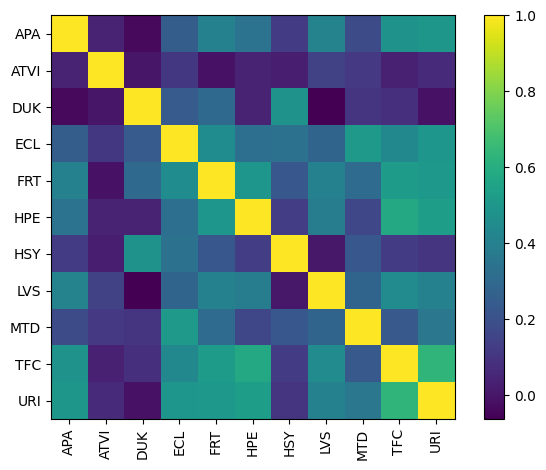

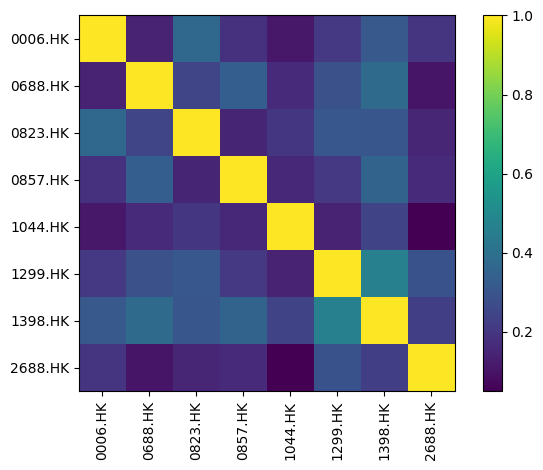

In [51]:
sp500_top_cov = pypfopt.risk_models.sample_cov(sp500_top_logtrain,frequency=1,returns_data=True)
# pypfopt.plotting.plot_covariance(sp500_top_cov,plot_correlation=True)
sp500_top_mu = pypfopt.expected_returns.mean_historical_return(sp500_top_logtrain,frequency=1,returns_data=True,compounding=False)

sp500_cov = pypfopt.risk_models.sample_cov(sp500_logtrain,frequency=1,returns_data=True)
pypfopt.plotting.plot_covariance(sp500_cov,plot_correlation=True)
sp500_mu = pypfopt.expected_returns.mean_historical_return(sp500_logtrain,frequency=1,returns_data=True,compounding=False)

hsi_cov = pypfopt.risk_models.sample_cov(hsi_logtrain,frequency=1,returns_data=True)
pypfopt.plotting.plot_covariance(hsi_cov,plot_correlation=True)
hsi_mu = pypfopt.expected_returns.mean_historical_return(hsi_logtrain,frequency=1,returns_data=True,compounding=False)

### Tested Portfolios

#### Portfolio #1: Markowitz Mean-Variance Portfolio (MVP)

\begin{array}{ll}
\underset{\mathbf{w}}{\textsf{maximize}} & \boldsymbol{\mu}^T\mathbf{w} -\lambda\mathbf{w}^T\mathbf{\Sigma}\mathbf{w}\\
{\textsf{subject to}}
 & \mathbf{1}^T\mathbf{w} = 1\\
 & \mathbf{w}\ge\mathbf{0}.
\end{array}

In [52]:
def MVP(mu, Sigma, lmd=0.5):
    w = cp.Variable(len(mu))
    variance = cp.quad_form(w, Sigma)
    expected_return = w @ mu
    problem = cp.Problem(cp.Minimize(lmd * variance - expected_return), [w >= 0, cp.sum(w) == 1])   
    problem.solve()
    return w.value

#### Portfolio #2: Global Minimum Variance Portfolio (GMVP)

\begin{array}{ll}
\underset{\mathbf{w}}{\textsf{minimize}} & \mathbf{w}^T\mathbf{\Sigma}\mathbf{w}\\
{\textsf{subject to}}
 & \mathbf{1}^T\mathbf{w} = 1\\
 & \mathbf{w}\ge\mathbf{0}
\end{array}

In [53]:
# function for GMVP
def GMVP(Sigma):
     w = cp.Variable(np.shape(Sigma)[0])
     variance = cp.quad_form(w, Sigma)
     problem = cp.Problem(cp.Minimize(variance),
                    [w >= 0, cp.sum(w) == 1])
     problem.solve()
     return w.value

#### Portfolio #3: Maximum Sharpe Ratio Portfolio (MSRP)

Nonconvex Form: 
\begin{array}{ll}
\underset{\mathbf{w}}{\textsf{maximize}} &
\dfrac{\mathbf{w}^{T}\boldsymbol{\mu}-r_{f}}{\sqrt{\mathbf{w}^{T}\boldsymbol{\Sigma}\mathbf{w}}}\\
\textsf{subject to} & \mathbf{1}^{T}\mathbf{w}=1, \quad\left(\mathbf{w}\geq\mathbf{0}\right)
\end{array}

Rewrite to convex form via schaible:
\begin{array}{ll}
\underset{\tilde{\mathbf{w}}}{\textsf{minimize}} & \tilde{\mathbf{w}}^T\mathbf{\Sigma}\tilde{\mathbf{w}}\\
{\textsf{subject to}}
 & \tilde{\mathbf{w}}^T\boldsymbol{\mu} = 1\\
 & \tilde{\mathbf{w}}\ge\mathbf{0}
\end{array}

#### Portfolio #4: Equally Weighted Portfolio (EWP)

$\mathbf{w} = \frac{1}{N}$

In [54]:
def EWP(num_stocks):
    return np.ones(num_stocks)/len(sp500_top)

In [55]:
def MSRP(mu, Sigma):
    w = cp.Variable(len(mu))
    variance = cp.quad_form(w, Sigma)
    problem = cp.Problem(cp.Minimize(variance), [w >= 0, w @ mu == 1])   
    problem.solve()
    return w.value/np.sum(w.value)

### Portfolio Testing

Weight Allocation

<AxesSubplot: title={'center': 'Portfolio Allocation'}>

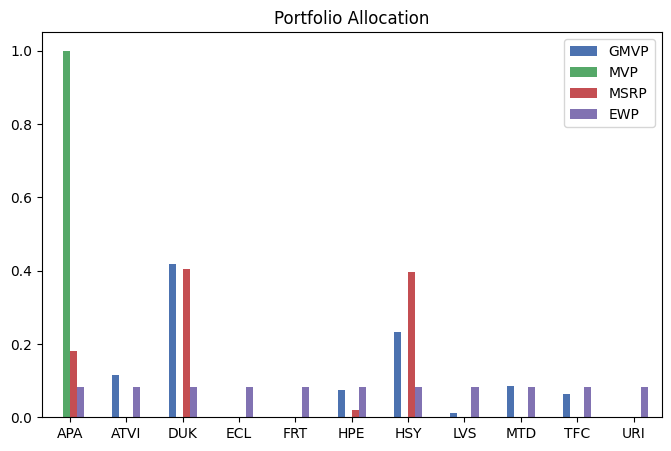

In [132]:
# Without PyPortfolioOpt Package
# MVP
test_mvp = MVP(sp500_mu,sp500_cov)
# GMVP
test_gmvp = GMVP(sp500_cov)

test_msrp = MSRP(sp500_mu,sp500_cov)

test_ewp = EWP(len(sp500_symbols))

sp500_test_portolio = pd.DataFrame(np.array([test_gmvp,test_mvp, test_msrp,test_ewp]).T,columns=["GMVP","MVP","MSRP","EWP"],index=sp500_prices.columns)


sp500_test_portolio.plot.bar(rot=0,figsize=(8,5),title="Portfolio Allocation")

In [ ]:
# Without PyPortfolioOpt Package
# MVP
test_mvp = MVP(sp500_mu,sp500_cov)
# GMVP
test_gmvp = GMVP(sp500_cov)

test_msrp = MSRP(sp500_mu,sp500_cov)

test_ewp = EWP(len(sp500_symbols))

test_portolio = pd.DataFrame(np.array([test_gmvp,test_mvp, test_msrp,test_ewp]).T,columns=["GMVP","MVP","MSRP","EWP"],index=sp500_prices.columns)


test_portolio.plot.bar(rot=0,figsize=(8,5),title="Portfolio Allocation")

<AxesSubplot: title={'center': 'Portfolio Allocation for Randomly Chosen  SP500 Stocks'}>

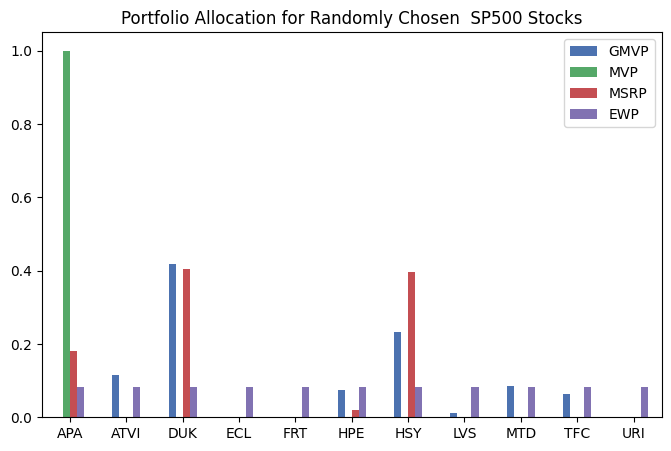

In [100]:
# With PyPortfolioOpt package
# GMVP
efgmvp = pypfopt.efficient_frontier.EfficientFrontier(sp500_mu,sp500_cov,weight_bounds=(0,1))
gmvp_weights = efgmvp.min_volatility()
# MVP
efmvp = pypfopt.efficient_frontier.EfficientFrontier(sp500_mu,sp500_cov,weight_bounds=(0,1))
mvp_weights = efmvp.max_quadratic_utility()

# EWP
ewp_weights = EWP(len(sp500_symbols))

# MSRP
efmsrp = pypfopt.efficient_frontier.EfficientFrontier(sp500_mu,sp500_cov,weight_bounds=(0,1))
msrp_weights = efmsrp.max_sharpe(risk_free_rate=0.0)


mvp_weights = pd.DataFrame(mvp_weights,index=['MVP']).iloc[0,:].values.tolist()
gmvp_weights = pd.DataFrame(gmvp_weights,index=['GMVP']).iloc[0,:].values.tolist()
msrp_weights = pd.DataFrame(msrp_weights,index=['MSRP']).iloc[0,:].values.tolist()

sp500_total_weights = pd.DataFrame(np.array([gmvp_weights,mvp_weights, msrp_weights, ewp_weights]).T,columns=["GMVP","MVP","MSRP", "EWP"],index=sp500_prices.columns)

sp500_total_weights.plot.bar(rot=0,figsize=(8,5),title="Portfolio Allocation for Randomly Chosen  SP500 Stocks")

<AxesSubplot: title={'center': 'Portfolio Allocation for Randomly Chosen HSI Stocks'}>

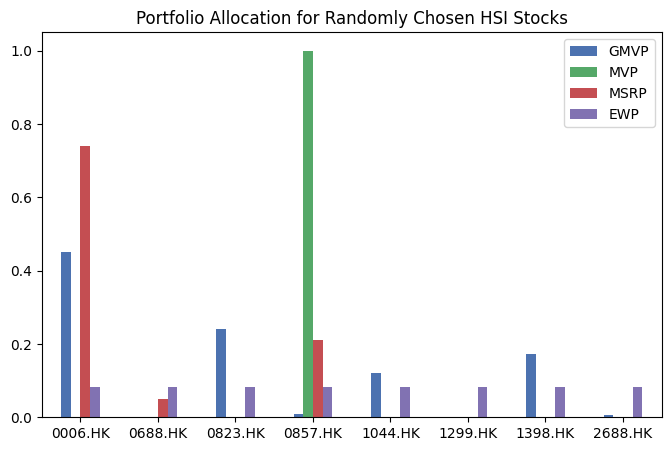

In [99]:
# With PyPortfolioOpt package
# GMVP
efgmvp = pypfopt.efficient_frontier.EfficientFrontier(hsi_mu,hsi_cov,weight_bounds=(0,1))
gmvp_weights = efgmvp.min_volatility()

# MVP
efmvp = pypfopt.efficient_frontier.EfficientFrontier(hsi_mu,hsi_cov,weight_bounds=(0,1))
mvp_weights = efmvp.max_quadratic_utility()

# EWP
ewp_weights = EWP(len(hsi_symbols))

# MSRP
efmsrp = pypfopt.efficient_frontier.EfficientFrontier(hsi_mu,hsi_cov,weight_bounds=(0,1))
msrp_weights = efmsrp.max_sharpe(risk_free_rate=0.0)

mvp_weights = pd.DataFrame(mvp_weights,index=['MVP']).iloc[0,:].values.tolist()
gmvp_weights = pd.DataFrame(gmvp_weights,index=['GMVP']).iloc[0,:].values.tolist()
msrp_weights = pd.DataFrame(msrp_weights,index=['MSRP']).iloc[0,:].values.tolist()

hsi_total_weights = pd.DataFrame(np.array([gmvp_weights,mvp_weights, msrp_weights, ewp_weights]).T,columns=["GMVP","MVP","MSRP", "EWP"],index=hsi_prices.columns)

hsi_total_weights.plot.bar(rot=0,figsize=(8,5),title="Portfolio Allocation for Randomly Chosen HSI Stocks")

Performance (in-sample vs out-sample)

In [109]:
sp500_ret_all = sp500_linear_returns @ sp500_total_weights
sp500_ret_trn = sp500_ret_all.iloc[:sp500_trn,]
sp500_ret_test = sp500_ret_all.iloc[sp500_trn:,]

# print("Training set return: ")
# print(emp.annual_return(sp500_ret_trn))

# print("\nTest set return: ")
# print(emp.annual_return(sp500_ret_test))

In [112]:
pd.DataFrame(emp.annual_return(sp500_ret_trn),columns=['SP500 Return (Training)'],index=sp500_ret_all.columns)

,SP500 Return (Training)
GMVP,0.187059
MVP,1.266245
MSRP,0.444169
EWP,0.151499


In [113]:
pd.DataFrame(emp.annual_return(sp500_ret_test),columns=['SP500 Return (Testing)'],index=sp500_ret_all.columns)

,SP500 Return (Testing)
GMVP,0.038969
MVP,0.058499
MSRP,0.067041
EWP,0.150249


In [114]:
pd.DataFrame(emp.annual_volatility(sp500_ret_trn),columns=['SP500 Volatility (Training)'],index=sp500_ret_all.columns)

,SP500 Volatility (Training)
GMVP,0.124561
MVP,0.578694
MSRP,0.163413
EWP,0.175940


In [115]:
pd.DataFrame(emp.annual_volatility(sp500_ret_test),columns=['SP500 Volatility (Testing)'],index=sp500_ret_all.columns)

,SP500 Volatility (Testing)
GMVP,0.181486
MVP,0.590502
MSRP,0.201995
EWP,0.214994


In [116]:
pd.DataFrame(emp.sharpe_ratio(sp500_ret_trn),columns=['SP500 Sharpe Ratio (Training)'],index=sp500_ret_all.columns)

,SP500 Sharpe Ratio (Training)
GMVP,1.439278
MVP,1.703482
MSRP,2.332261
EWP,0.889800


In [117]:
pd.DataFrame(emp.sharpe_ratio(sp500_ret_test),columns=['SP500 Sharpe Ratio (Testing)'],index=sp500_ret_all.columns)

,SP500 Sharpe Ratio (Testing)
GMVP,0.300730
MVP,0.391566
MSRP,0.421681
EWP,0.757857


In [118]:
hsi_ret_all = hsi_linear_returns @ hsi_total_weights
hsi_ret_trn = hsi_ret_all.iloc[:hsi_trn,]
hsi_ret_test = hsi_ret_all.iloc[hsi_trn:,]
# print("Training set return: ")
# print(emp.annual_return(hsi_ret_trn))
# print("\nTest set return: ")
# print(emp.annual_return(hsi_ret_test))

In [119]:
pd.DataFrame(emp.annual_return(hsi_ret_trn),columns=['HSI Return (Training)'],index=sp500_ret_all.columns)

,HSI Return (Training)
GMVP,0.098711
MVP,0.570376
MSRP,0.327674
EWP,0.084239


In [107]:
pd.DataFrame(emp.annual_return(hsi_ret_test),columns=['HSI Return (Testing)'],index=sp500_ret_all.columns)

,HSI Return (Testing)
GMVP,-0.183536
MVP,-0.079660
MSRP,-0.213446
EWP,-0.032479


In [120]:
pd.DataFrame(emp.annual_volatility(hsi_ret_trn),columns=['HSI Volatility (Training)'],index=sp500_ret_all.columns)

,HSI Volatility (Training)
GMVP,0.113199
MVP,0.352783
MSRP,0.144658
EWP,0.105849


In [121]:
pd.DataFrame(emp.annual_volatility(hsi_ret_test),columns=['HSI Volatility (Testing)'],index=sp500_ret_all.columns)

,HSI Volatility (Testing)
GMVP,0.170945
MVP,0.273809
MSRP,0.172373
EWP,0.148080


In [122]:
pd.DataFrame(emp.sharpe_ratio(hsi_ret_trn),columns=['HSI Sharpe Ratio (Training)'],index=sp500_ret_all.columns)

,HSI Sharpe Ratio (Training)
GMVP,0.888203
MVP,1.455126
MSRP,2.032445
EWP,0.816999


In [123]:
pd.DataFrame(emp.sharpe_ratio(hsi_ret_test),columns=['HSI Sharpe Ratio (Testing)'],index=sp500_ret_all.columns)

,HSI Sharpe Ratio (Testing)
GMVP,-1.100914
MVP,-0.165872
MSRP,-1.306353
EWP,-0.149714


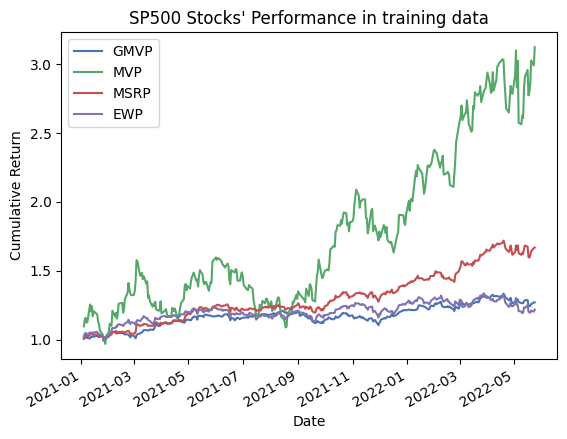

In [127]:
sp500_cum_ret = np.cumprod(1+sp500_ret_trn).plot(title="SP500 Stocks' Performance in training data",ylabel='Cumulative Return')

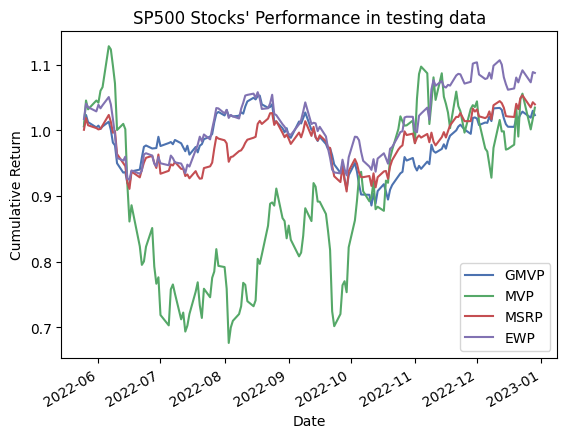

In [128]:
sp500_cum_ret = np.cumprod(1+sp500_ret_test).plot(title="SP500 Stocks' Performance in testing data",ylabel='Cumulative Return')

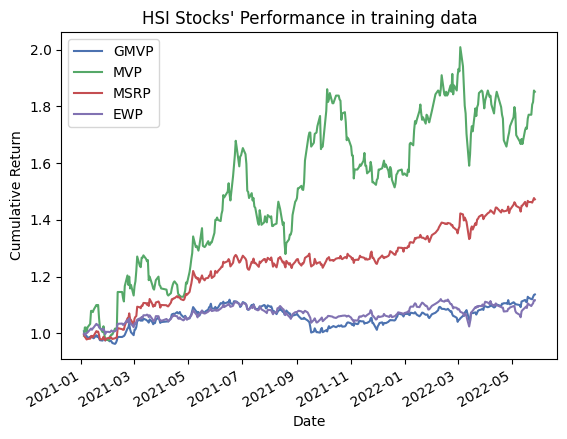

In [129]:
hsi_cum_ret = np.cumprod(1+hsi_ret_trn).plot(title="HSI Stocks' Performance in training data",ylabel='Cumulative Return')

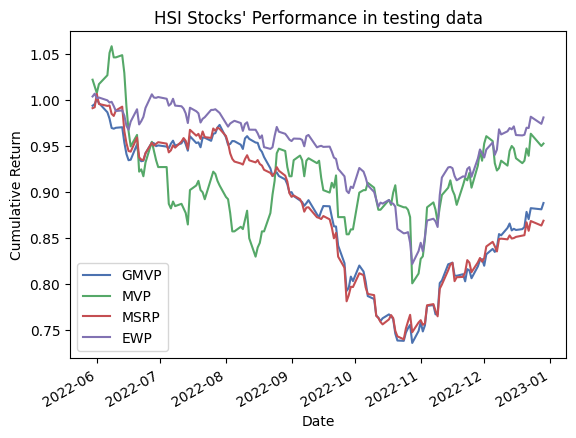

In [130]:
hsi_cum_ret = np.cumprod(1+hsi_ret_test).plot(title="HSI Stocks' Performance in testing data",ylabel='Cumulative Return')

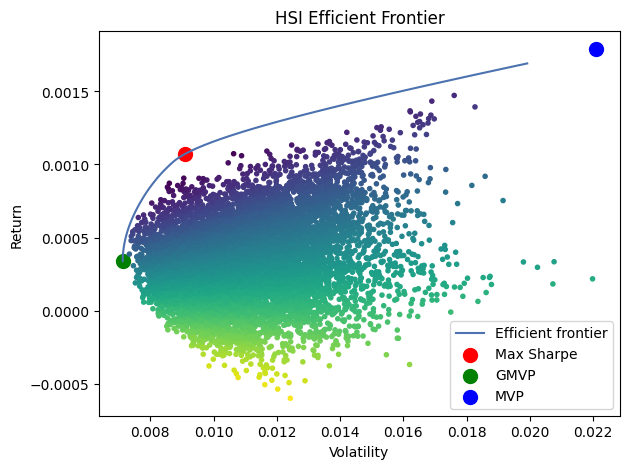

In [96]:

ef = pypfopt.efficient_frontier.EfficientFrontier(hsi_mu,hsi_cov,weight_bounds=(0,1))
fig, ax = plt.subplots()
ef_max_sharpe = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe(risk_free_rate=0)
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="o", s=100, c="r", label="Max Sharpe")


efgmvp = pypfopt.efficient_frontier.EfficientFrontier(hsi_mu,hsi_cov,weight_bounds=(0,1))
efgmvp.min_volatility()
ret_tangent, std_tangent, _ = efgmvp.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="o", s=100, c="g", label="GMVP")

efmvp = pypfopt.efficient_frontier.EfficientFrontier(hsi_mu,hsi_cov,weight_bounds=(0,1))
efmvp.max_quadratic_utility()
ret_tangent, std_tangent, _ = efmvp.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="o", s=100, c="b", label="MVP")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("HSI Efficient Frontier")
ax.legend()
plt.tight_layout()
plt.show()


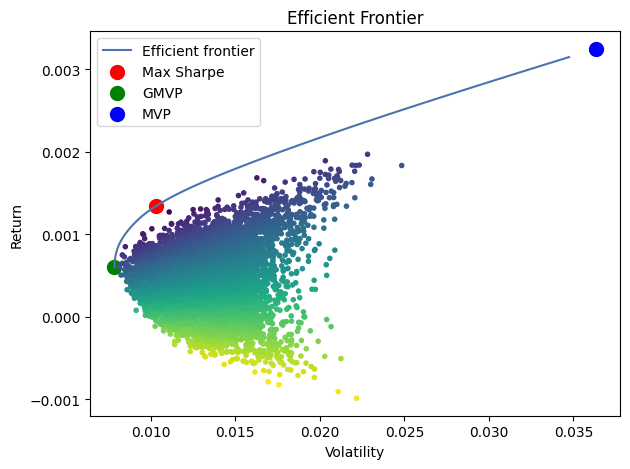

In [95]:

ef = pypfopt.efficient_frontier.EfficientFrontier(sp500_mu,sp500_cov,weight_bounds=(0,1))
fig, ax = plt.subplots()
ef_max_sharpe = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe(risk_free_rate=0)
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="o", s=100, c="r", label="Max Sharpe")

efgmvp = pypfopt.efficient_frontier.EfficientFrontier(sp500_mu,sp500_cov,weight_bounds=(0,1))
efgmvp.min_volatility()
ret_tangent, std_tangent, _ = efgmvp.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="o", s=100, c="g", label="GMVP")

efmvp = pypfopt.efficient_frontier.EfficientFrontier(sp500_mu,sp500_cov,weight_bounds=(0,1))
efmvp.max_quadratic_utility()
ret_tangent, std_tangent, _ = efmvp.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="o", s=100, c="b", label="MVP")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier")
ax.legend()
plt.tight_layout()
plt.show()


#### Resources:

- [Web scrap stocks](https://tcoil.info/)
- [Web scrap if read_html blocked](https://stackoverflow.com/questions/68249881/why-read-html-from-python-pandas-not-working)
- [Lecture Notes](https://palomar.home.ece.ust.hk/MAFS5310_lectures/slides_portfolio_optim.html#1)
- [PyPortfolioOpt Documentation](https://pyportfolioopt.readthedocs.io/en/latest/MeanVariance.html)
- [CVXPY Example Usage](https://www.cvxpy.org/examples/index.html)